In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from os.path import exists
import sys
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Sequential
from keras.layers import Dense
from collections import deque
import math
import random
import yfinance
%matplotlib inline
from keras.models import load_model
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from collections import deque 


In [ ]:
# Quick helper function skeletons
class RLOnEquities:
    def __init__(self, path):
        self.path = path
    def get_stock_data(self):
        #check if file exists 
        if(not exists(self.path)):
            print("File does not exist")
            sys.exit()
        #read file
        self.data = pd.read_csv(self.path)
        self.data.set_index('Date')
        self.data.index = pd.to_datetime(self.data['Date'])
        if not self.data.empty:
            print("Dataframe loaded succesfully.")
        print(self.data)
    def plot_stock_data(self):
        # Plot adjusted close over our data

        plt.figure(figsize=(20,8))
        plt.plot(self.data.index,'Adj Close',data = self.data)
        plt.xlabel('Date')
        plt.ylabel('Adjusted Close')
        plt.title('JPY/USD Price')
        plt.show()

        # Plot Volume data 

        #plt.figure(figsize=(20,8))
        #plt.plot(self.data.index, 'Volume', data = self.data)
        #plt.xlabel('Date')
        #plt.ylabel('Volume')
        #plt.title('JPY/USD Volume')
        #plt.show()

        # Plot corr matrix

        self.data.corr()
        f,ax = plt.subplots(figsize=(9, 9))
        sns.heatmap(self.data.corr(), annot=True, linewidths=.9, fmt= '.1f',ax=ax)
        plt.title('Correlation Matrix')
        plt.show()

    def performance_analysis(self):
        # To get a better understanding of how bitcoin has performed over our timeframe, analyze it against the S&P 500 index
        # Use yfinance package to download the index data
        spx =  yfinance.download('^GSPC', 
                      start='2014-09-17', 
                      end='2021-11-17', 
                      progress=False)

        # Plot the prices against each other
        plt.figure(figsize = (20,8))
        plt.plot(spx.index, 'Adj Close', data = spx, color = 'red', label = 'S&P 500')
        plt.plot(self.data.index, 'Adj Close', data = self.data, color = 'blue', label = 'Bitcoin')
        plt.xlabel('Date')
        plt.ylabel('Price')
       
        plt.title('S&P 500 Index v. Bitcoin Price')
        plt.legend()
        plt.show()

        #Plot the volumes against each other 
        plt.figure(figsize = (20,8))
        plt.plot(spx.index, 'Volume', data = spx, color = 'red', label = 'S&P 500')
        plt.plot(self.data.index, 'Volume', data = self.data, color = 'blue', label = 'Bitcoin')
        plt.xlabel('Date')
        plt.ylabel('Volume')
        plt.title('S&P 500 v. Bitcoin Volume')
        plt.show()

        jpy_daily_return = self.get_daily_return(self.data)
        sp500_daily_return = self.get_daily_return(spx)
        plt.figure(figsize = (20,8))
        plt.plot(spx.index, sp500_daily_return, color = 'red', label = 'S&P 500')
        plt.xlabel('Date')
        plt.ylabel('Daily Return')
        plt.title('S&P 500 daily returns')
        plt.show()
        btc_sharpe_ratio = self.get_sharpe_ratio(self.data, 365)
        spx_sharpe_ratio = self.get_sharpe_ratio(spx, 252)
        print(btc_sharpe_ratio)
        print(spx_sharpe_ratio)


        plt.figure(figsize = (20,8))
        plt.plot(self.data.index, jpy_daily_return, color = 'blue', label = 'Bitcoin')
        plt.xlabel('Date')
        plt.ylabel('Daily Return')
        plt.title('JPY Daily Return')
        plt.show()
        
        

    def get_daily_return(self,data):
        daily_returns = data['Adj Close'].pct_change()
        return np.array(daily_returns)

    # 
    def get_sharpe_ratio(self,data,days):
        daily_return = self.get_daily_return(data)
        return (days ** 0.5) * (np.mean(daily_return[1:])/np.std(daily_return[1:]))
    
    


Dataframe loaded succesfully.
                  Date          Open          High           Low  \
Date                                                               
2014-09-17  2014-09-17    465.864014    468.174011    452.421997   
2014-09-18  2014-09-18    456.859985    456.859985    413.104004   
2014-09-19  2014-09-19    424.102997    427.834991    384.532013   
2014-09-20  2014-09-20    394.673004    423.295990    389.882996   
2014-09-21  2014-09-21    408.084991    412.425995    393.181000   
...                ...           ...           ...           ...   
2021-11-13  2021-11-13  64158.121094  64915.675781  63303.734375   
2021-11-14  2021-11-14  64455.371094  65495.179688  63647.808594   
2021-11-15  2021-11-15  65521.289063  66281.570313  63548.144531   
2021-11-16  2021-11-16  63721.195313  63721.195313  59016.335938   
2021-11-17  2021-11-17  59967.230469  66304.296875  58838.714844   

                   Close     Adj Close        Volume  
Date                          

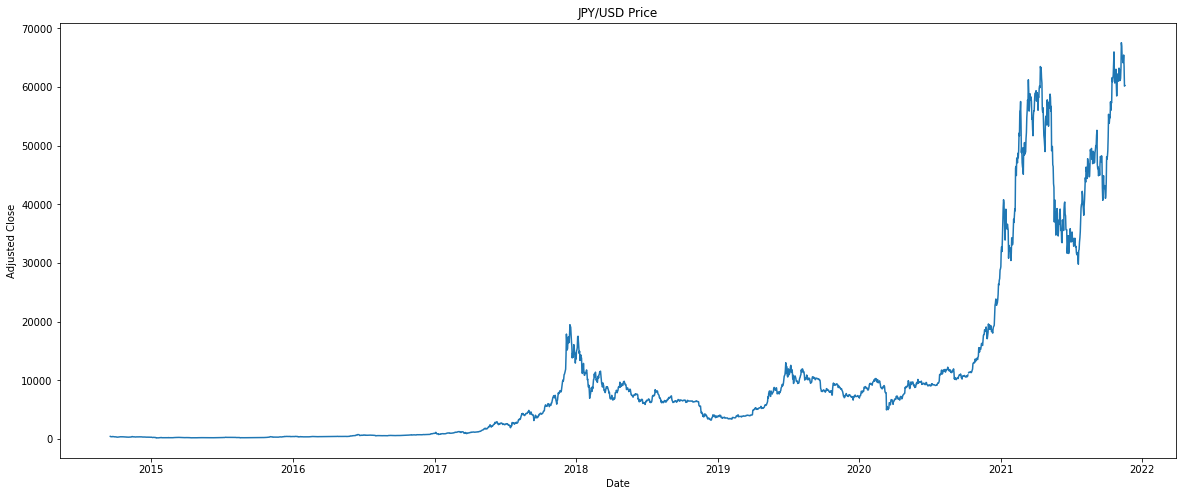

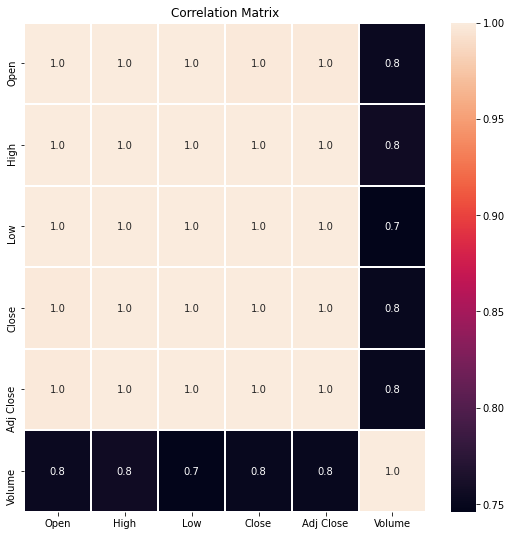

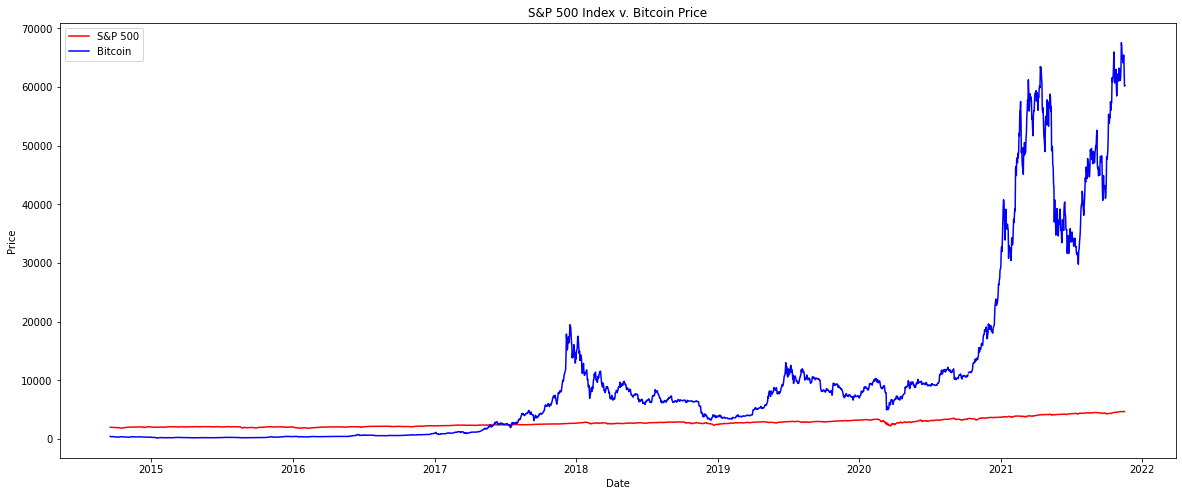

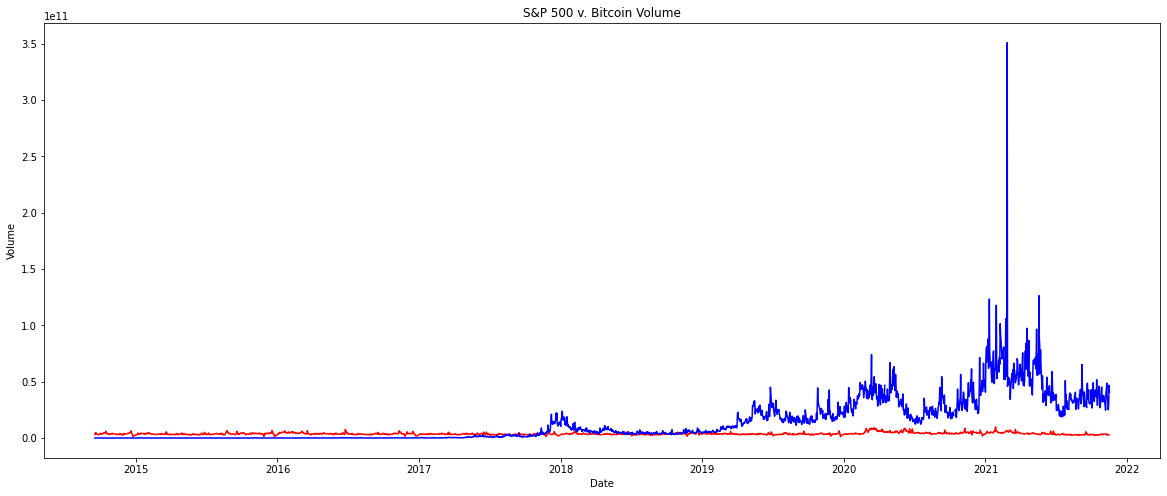

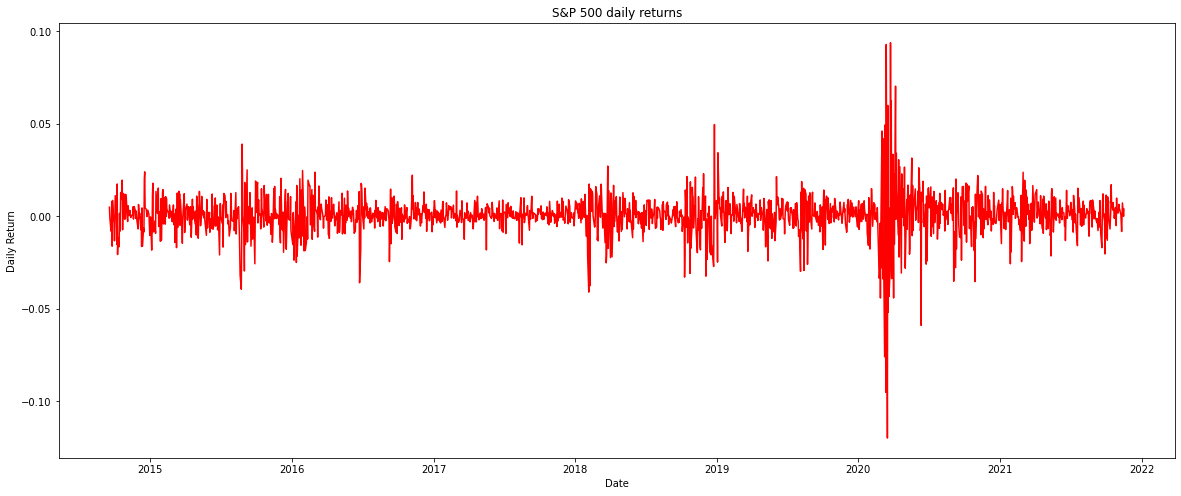

1.290234763074413
0.7583225121811163


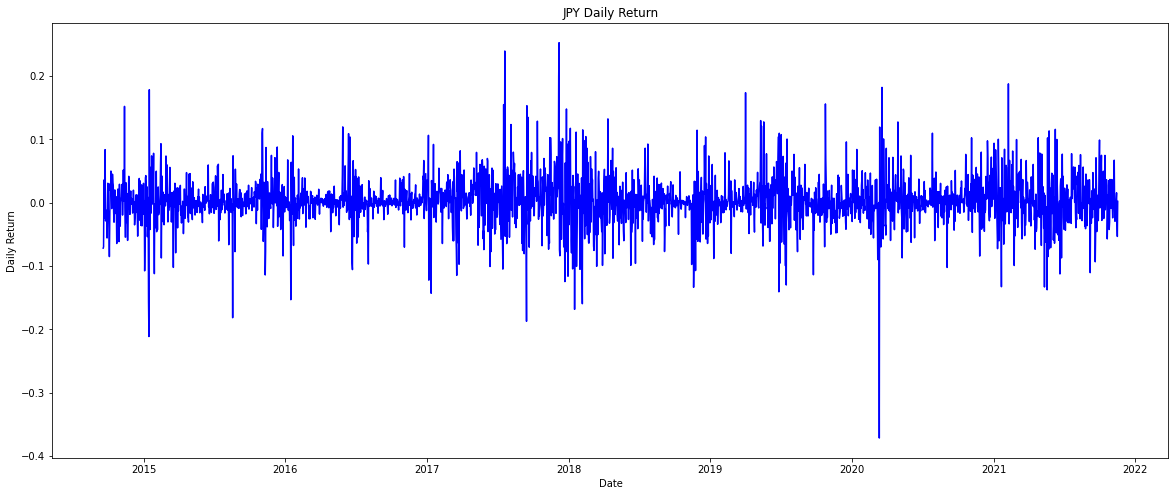

In [3]:
object = RLOnEquities('data/BTC-USD.csv')
object.get_stock_data()
object.plot_stock_data()
object.performance_analysis()

In [ ]:
class Trader:
    def __init__(self, state_size, is_eval=False, model_name=""):
        self.state_size = state_size # normalized previous days
        self.action_size = 3 # hold, buy, sell
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval
        self.gamma = 0.95    #Q = r(s, a) + Gamma(max(Q(s, a))) 
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = load_model(model_name) if is_eval else self._model()
    
    def _model(self):
        model = Sequential()
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(lr=0.001))
        return model
    
    def act(self, state):
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        options = self.model.predict(state)
        return np.argmax(options[0])
    
    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])
        for state, action, reward, next_state, done in mini_batch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

#---------------------------------------------------------------------------------------------------

# HELPER FUNCTIONS

def formatPrice(n):
  return("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

def getStockDataVec(key):
  og_data = []
  d1 = []
  d2 = []
  data = []
  #rsi = []
  lines = open(key+".csv","r").read().splitlines()
  for line in lines[15:]:
    d1.append(line.split(",")[0])
    d2.append(float(line.split(",")[5]))
    data.append(float(line.split(",")[5]))
    #rsi.append(float(line.split(",")[8])) 
  og_data.append(d1)
  og_data.append(d2) 
  return data, og_data  

def sigmoid(x):
  return 1/(1+math.exp(-x))

def getState(data, t, n): #getState(data, rsi, t, n)
  d = t - n + 1
  if d >= 0:
      block1 = data[d:t+1]
      #block2 = rsi[d:t+1] 
  else:
      block1 = -d * [data[0]] + data[0:t+1] # pad with t0
      #block2 = -d * [rsi[0]] + rsi[0:t+1] # pad with t0
  res = []
  for i in range(n-1):
      res.append((sigmoid(block1[i+1] - block1[i]))) 
  return np.array([res])

def plot_decisions(buys, sells, data):
  length = len(data[0])
  weeks = []
  for i in range(1, length+1):
    weeks.append(i)
  # Line Plot of Market Data
  # Line color should be blue
  plt.figure(figsize=(20,8))
  plt.plot(weeks, data[1], color='black') # need to fill in 

  # Deep Q scatter color is red
  plt.scatter(buys[0], buys[1], marker='^', color='red')
  plt.scatter(sells[0], sells[1], marker='v', color='blue')

  # Labels Design
  plt.xlabel('Date')
  plt.ylabel('Adjusted Close') 
  plt.title('Buy Sell Times')

  # Display Plot 
  plt.show()

def plot_accumulating_profits(deep_Q_profits):
  deep_Q_accumulating_profits = accumulating_loop(deep_Q_profits)

  # Plots 
  plt.plot(deep_Q_profits[0], deep_Q_accumulating_profits, color='red')

  # Labels Design
  plt.xlabel('Date')
  plt.ylabel('Profit')
  plt.title('Accumulating Profits')

  # Display Plot
  plt.show()
    
def accumulating_loop(profits):
  accumulating_profits = [profits[1][0]]
  for i in range(1, len(profits[1])):
    accumulating_profits.append(profits[1][i] + accumulating_profits[i-1]) 
  return accumulating_profits 
    
def plot_profits(deep_Q_profits):
  length = len(deepQ_profits[0])
  weeks = []
  for i in range(1, length+1):
    weeks.append(i)
  # Plots 
  plt.plot(deep_Q_profits[0], deep_Q_profits[1], color='red')

  # Labels Design
  plt.xlabel('Date')
  plt.ylabel('Profit')
  plt.title('Weekly Profits')

  # Display Plot
  plt.show()

#---------------------------------------------------------------------------------------------------

ticker = input("Enter ticker name")
stock_name = "data/" +  ticker
window_size = int(input("Enter window_size, Episode_count, Starting Balance(must > 30,000), Risk(5% = 0.05)\n"))
episode_count = int(input()) # amount of times we run through the entire training set 
pre_balance = int(input()) # amount the trader starts with 
risk = float(input()) # amount of risk per trade 
trader = Trader(window_size)
data, og_data = getStockDataVec(stock_name)
length = len(data) - 1
batch_size = 32
buys = []
sells = []
profits = []
for e in range(1, episode_count + 1):
  print("Episode: " + str(e) + "/" + str(episode_count))
  state = getState(data, 0, window_size + 1) 
  total_profit = 0
  trader.inventory = []
  stocks_bought = []
  post_balance = pre_balance 
  buy_times = []
  buy_price = []
  sell_times = []
  sell_price = []
  profit_list = []
  profit_date = []
  for t in range(length):
    print("working")
    action = trader.act(state)
    # hold
    next_state = getState(data, t+1, window_size + 1) 
    reward = 0
        
    if action == 1 and post_balance > data[t]: # bought
      bought_price = data[t] 
      #bought_time = og_data[0][t] 
      bought_time = t
      #print("stock_price: " + formatPrice(bought_price)) 
      money_to_trade = post_balance * risk 
      stock_amount = int(money_to_trade / bought_price) 
      trader.inventory.append(bought_price)
      stocks_bought.append(stock_amount)
      post_balance = post_balance - (stock_amount * bought_price)
      if e % episode_count == 0:
        buy_times.append(bought_time)
        buy_price.append(bought_price)
    elif action == 2 and len(trader.inventory) > 0: # sold 
      sold_price = data[t]  
      #sold_time = og_data[0][t]
      sold_time = t 
      bought_price = window_size_price = trader.inventory.pop(0)
      stock_amount = stocks_bought.pop(0) 
      profit = (sold_price * stock_amount) - (bought_price * stock_amount)
      reward = max(profit, 0)
      #total_profit += data[t] - bought_price
      #total_profit += profit 
      post_balance = post_balance + (sold_price * stock_amount)
      if e % episode_count == 0:
        sell_times.append(sold_time)
        sell_price.append(sold_price)
        profit_list.append(profit)
        profit_date.append(sold_time)
         
    if t == length-1:
      done = True
    else:
      done = False 

    trader.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
      if e % episode_count == 0:
        buys.append(buy_times)
        buys.append(buy_price)
        sells.append(sell_times)
        sells.append(sell_price)
        profits.append(profit_date)
        profits.append(profit_list)

    if len(trader.memory) > batch_size:
      trader.expReplay(batch_size)

  if e % episode_count == 0:
    trader.model.save(str(e))

deepQ_buys = [buys[0], buys[1]]
deepQ_sells = [sells[0], sells[1]]
deepQ_profits = [profits[0], profits[1]] 

plot_decisions(deepQ_buys, deepQ_sells, og_data)

plot_accumulating_profits(deepQ_profits)

plot_profits(deepQ_profits) 